In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.dates as mdates

from collections import defaultdict
import seaborn as sns

import mapclassify

from StreamFlowEvents_Utils import *

# Gauge Data Visualizations

## Watersheds & Gauge Locations

In [2]:
# path to gauge location shapefile
input_gauge_path = r'../Data/stream_gauges/KY_StreamGaugeLocations_26916.shp'

# path to watershed boundary shapefile
input_watersheds_path = r'../Data/nhd/ky_huc10_26916.shp'

# read shapefiles into geodataframes...
gdf_gauges = gpd.read_file(input_gauge_path)            # all gauges with their containing HUC10 watershed ID (points)
gdf_watersheds = gpd.read_file(input_watersheds_path)   # all watersheds with or without gauges (polygons)

# convert datetime columns to datetime dtype
gdf_gauges[['gh_start', 'gh_end', 'sf_start', 'sf_end']] = gdf_gauges[['gh_start', 'gh_end', 'sf_start', 'sf_end']].apply(pd.to_datetime)

# convert timedelta columns to timedelta
gdf_gauges[['gh_diff', 'sf_diff']] = gdf_gauges[['gh_diff', 'sf_diff']].apply(pd.to_timedelta)

In [3]:
# create indicator variable for presence of stream gauge in watershed; 0 is no gauge present
gdf_watersheds['gauge'] = 0

# mask watersheds geodataframe for only watersheds that are in gdf_gauges, then set indicator variable to 1
gdf_watersheds.loc[gdf_watersheds['huc10'].isin(gdf_gauges['huc10'].unique()), 'gauge'] = 1

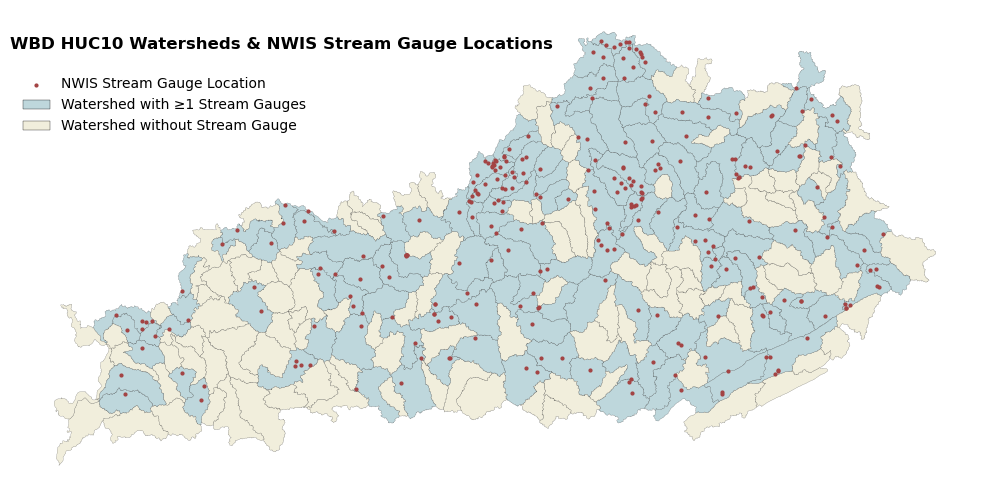

In [4]:
# plot watersheds (that intersect Kentucky only) and stream gauge locations...
fig, ax = plt.subplots(figsize=(10,7))

# define colormap for watershed polygons
watershed_colors = ListedColormap(['#F1EEDC', '#BED7DC'], 'watershed_colors')

# plot watershed polygons
gdf_watersheds.plot(column='gauge', ax=ax, cmap=watershed_colors, edgecolor='k', linewidth=0.1)

# plot stream gauge locations
gdf_gauges.plot(ax=ax, markersize=4, color='#A34343')

# create custom legend handles
legend_handles = [plt.scatter([], [], s=4, c='#A34343', label='NWIS Stream Gauge Location'), 
                  Patch(facecolor='#BED7DC', edgecolor='k', linewidth=0.25, label='Watershed with \u22651 Stream Gauges'),
                  Patch(facecolor='#F1EEDC', edgecolor='k', linewidth=0.25, label='Watershed without Stream Gauge')]

# add legend with custom legend handles
ax.legend(handles=legend_handles, bbox_to_anchor=(0, 0.8), loc='center left', frameon=False)

ax.set_title('WBD HUC10 Watersheds & NWIS Stream Gauge Locations', weight='bold', loc='left', y=0.9)

ax.set_axis_off()
plt.tight_layout()
plt.show()

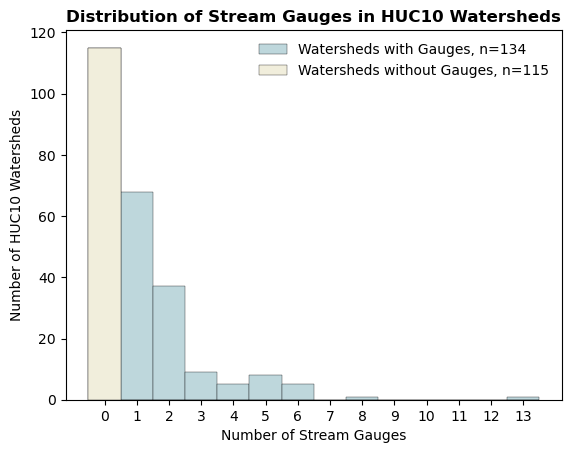

In [5]:
# histogram show stream gauge count for watersheds...
# get counts of watersheds with stream gauges
gauge_counts = gdf_gauges['huc10'].value_counts()

# add watersheds with no stream gauges...
for watershed in gdf_watersheds.loc[gdf_watersheds['gauge'] == 0, 'huc10']:
    gauge_counts.loc[watershed] = 0

# plot histogram of counts...
fig, ax = plt.subplots()

# define bins that align centered on bin number...
min_count = gauge_counts.min()
max_count = gauge_counts.max()
bin_edges = np.arange(min_count - 0.5, max_count + 1.5, 1)

# plot histogram for watersheds with stream gauges
ax.hist(gauge_counts, bins=bin_edges, color='#BED7DC', edgecolor='k', linewidth=0.25, 
        label=f'Watersheds with Gauges, n={(gauge_counts.values>0).sum()}')

# plot histogram for watersheds without stream gauges
ax.hist([0], bins=bin_edges, weights=[(gdf_watersheds['gauge']==0).sum()], color='#F1EEDC', edgecolor='k', linewidth=0.25, 
        label=f'Watersheds without Gauges, n={(gauge_counts.values==0).sum()}')

# customize plot...
ax.legend(frameon=False)
ax.grid(False)
ax.set_xticks(range(min_count, max_count + 1))
ax.set_xlabel('Number of Stream Gauges')
ax.set_ylabel('Number of HUC10 Watersheds')
ax.set_title('Distribution of Stream Gauges in HUC10 Watersheds', weight='bold')

plt.show()

## Stage Hydrographs

In [6]:
def get_timegap_indices(df, timegap_threshold):
    """Funciton to identify time gaps in timeseries and return start and end indices of gaps."""
    
    # get only non-null values (resample still keeps all data even if null and causes problems for diff)
    df_notna = df[df.notna().all(axis=1)]

    # calculate timedelta between sequential observations
    diff = df_notna.index.diff()

    # get ending datetime indices for time gaps
    end_gap_idx = df_notna[diff > pd.Timedelta(timegap_threshold)].index

    # get list of locational positions (integers) for start indices of time gaps
    start_gap_idx = [df_notna.index.get_loc(end) - 1 for end in end_gap_idx]

    # add start and end locations positions to capture entire dataset
    start_gap_idx.extend([0, -1])

    # convert start date indices to datetime indices
    start_gap_idx = df_notna.index[start_gap_idx]

    # union start and end datetime indices
    datetime_indices = start_gap_idx.union(end_gap_idx)

    return datetime_indices
    # return start_gap_idx, end_gap_idx

In [7]:
from scipy.stats import t

In [8]:
def moving_ma_and_moe(rolling, alpha=0.01):
    ma = rolling.mean()
    std = rolling.std()
    count = rolling.count()
    t_critical = t.ppf(1 - alpha/2, count-1)
    moe = (t_critical * std / np.sqrt(count))
    return ma.values.ravel(), moe.values.ravel()

In [9]:
def moving_percentile(rolling, percentile):
    q = percentile/100
    return rolling.quantile(q=q).values.ravel()

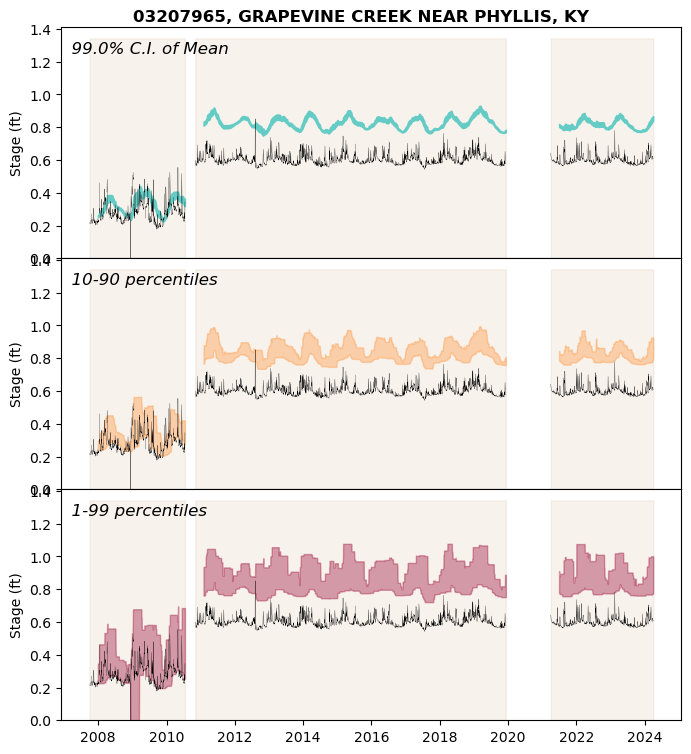

In [11]:
##### iterate through all stream gauges collecting gauge height data...
for gauge in gdf_gauges.loc[gdf_gauges['gh']==1, 'site_no']:

    ##### parameters...
    # data resample rule
    resample_time = '1d'

    # moving threshold window rule
    threshold_window = '90d'

    # timegap threshold rule (days; 3*moving threshold window...1 window before and 1 window after)
    timegap_threshold = '10d'

    # signficance level for confidence interval
    alpha = 0.01

    
    ##### read timeseries data from .csv...
    # path to file
    input_path = glob.glob(f'../Data/stream_gauges/gauge_height/{gauge}*.csv')[0]
    
    # custom function (read, clean, cast to datetime, timeseries resample)
    df = read_and_prepare_data(input_path, columns_to_drop=[0,1,3,5], resample=resample_time, log_transform=True)


    ##### plot hydrograph...
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,9))

    # flatten ax for indexing access
    ax = ax.ravel()

    # plot resampled timeseries data on all subplots
    for axes in ax:
        
        # plot log-transformed data
        axes.plot(df.index, np.log1p(df.iloc[:,0]), linewidth=0.2, color='k')


    ##### identify gaps in timeseries... 
    # custom function (get start and end indices for time gaps meeting threshold)
    timegap_indices = get_timegap_indices(df, timegap_threshold)

    # copy dataframe to hold threshold value results compilations
    df_thresholds = df.copy()
    
    # initialize columns to hold threshold calculation results...
    for col in ['q01', 'q01_lowevent', 'q10', 'q10_lowevent', 'lower99ci', 'lower99ci_lowevent', 'ma', 
                'upper99ci', 'upper99ci_highevent', 'q90', 'q90_highevent', 'q99', 'q99_highevent']:
        df_thresholds[col] = np.nan
    
    ##### iterate through timegap subsets...
    for idx in range(0, len(timegap_indices), 2):

        # define start and end datetime indices for subset
        start, end = timegap_indices[idx], timegap_indices[idx+1]

        # get subset
        df_subset = df[start:end]

        # interpolate missing values (less than timegap threshold since that's what defines our subsets)
        df_subset = df_subset.interpolate(method='linear', limit_direction='both')

        # calculate total duration (timedelta) of subset
        duration = df_subset.index.max() - df_subset.index.min()

        # if duration is greater than two times the threshold window then continue with subset calculations...
        if duration >= 2*pd.Timedelta(threshold_window):

            ##### calculate rolling thresholds...
            # note: min_periods requires at least that many days to perform calculations
            rolling = df_subset.rolling(threshold_window, min_periods=pd.to_timedelta(threshold_window).days)
            
            # calculate moving average (base flow) & margin of error of mean (t distribution)
            ma, moe = moving_ma_and_moe(rolling, alpha=alpha)

            # calculate upper and lower confidence intervals of the mean; ravel to 1D array
            upper99ci = ma + moe
            lower99ci = ma - moe

            # 99,90,10, and 1 percentiles...
            q99 = moving_percentile(rolling, 99)
            q90 = moving_percentile(rolling, 90)
            q10 = moving_percentile(rolling, 10)
            q01 = moving_percentile(rolling, 1)

            # compile threshold values in original dataframe
            df_thresholds.loc[start:end, 'q01'] = q01
            df_thresholds.loc[start:end, 'q10'] = q10
            df_thresholds.loc[start:end, 'lower99ci'] = lower99ci
            df_thresholds.loc[start:end, 'ma'] = ma
            df_thresholds.loc[start:end, 'upper99ci'] = upper99ci
            df_thresholds.loc[start:end, 'q90'] = q90
            df_thresholds.loc[start:end, 'q99'] = q99

            
            ##### plot subset data (not plotted if it doesn't meet duration)...
            # plot fill to indicate subset is used; zorder <1 ensures fill is behind other plot elements
            for axes in ax:
                axes.fill_between(x=df_subset.index, y1=0, y2=df.max().iloc[0], color='#DAC0A3', alpha=0.2, zorder=0.5)

            # plot condidence interval of the mean on first plot
            ax[0].fill_between(x=df_subset.index, y1=upper99ci, y2=lower99ci, color='#64CCC5', alpha=1)
            ax[0].set_title(f"  {(1-alpha)*100}% C.I. of Mean", style='italic', loc='left', y=0.85)

            # plot 10 and 90 percentiles on second plot
            ax[1].fill_between(x=df_subset.index, y1=q90, y2=q10, color='#FF9843', alpha=0.4)
            ax[1].set_title(f"  10-90 percentiles", style='italic', loc='left', y=0.85)

            # plot 1 and 99 percentiles on third plot
            ax[2].fill_between(x=df_subset.index, y1=q99, y2=q01, color='#A0153E', alpha=0.4)
            ax[2].set_title(f"  1-99 percentiles", style='italic', loc='left', y=0.85)


    # ##### identify events...
    # # low flow events
    # for low_col in ['q01', 'q10', 'lower99ci']:
    #     low_event_col = f"{low_col}_lowevent"
    #     df_thresholds[low_event_col] = 0
    #     df_thresholds.loc[df_thresholds['mean_1d'] <= df_thresholds[low_col], low_event_col] = 1

    # # high flow events
    # for high_col in ['upper99ci', 'q90', 'q99']:
    #     high_event_col = f"{high_col}_highevent"
    #     df_thresholds[high_event_col] = 0
    #     df_thresholds.loc[df_thresholds['mean_1d'] >= df_thresholds[high_col], high_event_col] = 1


    ##### calculate frequencies...

        
    '''maybe do this by subset - bouth counts (above) and frequencies - then get final average 
    annual frequency for each threshold over all busets'''


    '''Maybe KDE or rugplot instead of all points?'''

    

    # ##### plot events...
    # # condidence interval of mean events...
    # uppermask = df_thresholds['upper99ci_highevent'] == 1
    # high_label = f"High Event (n={uppermask.sum()})"
    # ax[0].scatter(x=df_thresholds[uppermask].index, y=df_thresholds.loc[uppermask, 'mean_1d'], s=2, c='red', alpha=0.2, label=high_label)
    
    # lowermask = df_thresholds['lower99ci_lowevent'] == 1
    # low_label = f"Low Event (n={lowermask.sum()})"
    # ax[0].scatter(x=df_thresholds[lowermask].index, y=df_thresholds.loc[lowermask, 'mean_1d'], s=2, c='blue', alpha=0.2, label=low_label)
    # ax[0].legend(frameon=False)
    
    # # 10-90 percentile events...
    # uppermask = df_thresholds['q90_highevent'] == 1
    # high_label = f"High Event (n={uppermask.sum()})"
    # ax[1].scatter(x=df_thresholds[uppermask].index, y=df_thresholds.loc[uppermask, 'mean_1d'], s=2, c='red', alpha=0.2, label=high_label)
    
    # lowermask = df_thresholds['q10_lowevent'] == 1
    # low_label = f"Low Event (n={lowermask.sum()})"
    # ax[1].scatter(x=df_thresholds[lowermask].index, y=df_thresholds.loc[lowermask, 'mean_1d'], s=2, c='blue', alpha=0.2, label=low_label)
    # ax[1].legend(frameon=False) 

    # # 1-99 percentile events...
    # uppermask = df_thresholds['q99_highevent'] == 1
    # high_label = f"High Event (n={uppermask.sum()})"
    # ax[2].scatter(x=df_thresholds[uppermask].index, y=df_thresholds.loc[uppermask, 'mean_1d'], s=2, c='red', alpha=0.2, label=high_label)
    
    # lowermask = df_thresholds['q01_lowevent'] == 1
    # low_label = f"Low Event (n={lowermask.sum()})"
    # ax[2].scatter(x=df_thresholds[lowermask].index, y=df_thresholds.loc[lowermask, 'mean_1d'], s=2, c='blue', alpha=0.2, label=low_label)
    # ax[2].legend(frameon=False)

    
    ##### legend, labels, y-limits, titles...
    # ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncols=2, frameon=False)
    [axes.set_ylim(bottom=0) for axes in ax]
    [axes.set_ylabel('Stage (ft)') for axes in ax]
    [axes.tick_params(labelbottom=False) for axes in ax[:2]]
    name = gdf_gauges.loc[gdf_gauges['site_no']==gauge, 'station_nm'].values[0]
    plt.suptitle(f"{gauge}, {name}", weight='bold', y=0.90)
    plt.subplots_adjust(hspace=0)


    # ##### save figures
    # output_path = f'stage_hydrographs/{gauge}_StageHydrograph.jpg'
    # plt.savefig(output_path, bbox_inches='tight')

    # plt.close()
    
    break

In [13]:
df

,mean_1d
datetime,
2007-10-01,0.237647
2007-10-02,0.239345
2007-10-03,0.242047
2007-10-04,0.242701
2007-10-05,0.238689
...,...
2024-03-30,0.845734
2024-03-31,0.841567
2024-04-01,0.837338


In [12]:
df_thresholds

,mean_1d,q01,q01_lowevent,q10,q10_lowevent,lower99ci,lower99ci_lowevent,ma,upper99ci,upper99ci_highevent,q90,q90_highevent,q99,q99_highevent
datetime,,,,,,,,,,,,,,
2007-10-01,0.237647,NaN,0,NaN,0,NaN,0,NaN,NaN,0,NaN,0,NaN,0
2007-10-02,0.239345,NaN,0,NaN,0,NaN,0,NaN,NaN,0,NaN,0,NaN,0
2007-10-03,0.242047,NaN,0,NaN,0,NaN,0,NaN,NaN,0,NaN,0,NaN,0
2007-10-04,0.242701,NaN,0,NaN,0,NaN,0,NaN,NaN,0,NaN,0,NaN,0
2007-10-05,0.238689,NaN,0,NaN,0,NaN,0,NaN,NaN,0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-30,0.845734,0.772535,0,0.792804,0,0.837700,0,0.852085,0.866470,0,0.92621,0,1.0011,0
2024-03-31,0.841567,0.772535,0,0.795873,0,0.838604,0,0.852815,0.867027,0,0.92621,0,1.0011,0
2024-04-01,0.837338,0.772535,0,0.798917,0,0.839496,1,0.853522,0.867548,0,0.92621,0,1.0011,0


## Discharge Hydrographs

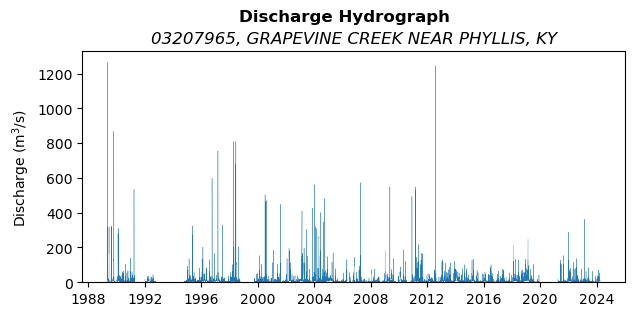

In [12]:
for gauge in gdf_gauges.loc[gdf_gauges['sf']==1, 'site_no']:

    name = gdf_gauges.loc[gdf_gauges['site_no']==gauge, 'station_nm'].values[0]
    input_path = glob.glob(f'../Data/stream_gauges/streamflow/{gauge}*.csv')[0]
    df = read_and_prepare_data(input_path, columns_to_drop=[0,1,3,5], resample='1h')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,3))
    ax.plot(df.index, df.iloc[:,0], linewidth=0.25, label=f"{gauge}")
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Discharge (m$^3$/s)')
    ax.set_title(f"{gauge}, {name}", style='italic')
    fig.suptitle('Discharge Hydrograph', weight='bold', y=1.02)

    # output_path = f'discharge_hydrographs/{gauge}_DischargeHydrograph.jpg'
    # plt.savefig(output_path, bbox_inches='tight')

    # plt.close()
    
    break

# High Flow Events

## Stage HFE

In [ ]:
# pre-processing
    # minimum sequential measurement window (e.g., at least one window of 365 sequential daily measurements)
    # subset and resample data

# for all thresholds...
    # calculate threshold
    # identify HFE
    # create indicator variable for HFE
    # get total count of HFE
    # get count of viable time windows
    # get average of HFE count for window of interest
    # get margin of error of HFE count for window of interest

# plot (similar to gauge hydrographs)...
    # plot resampled raw data timeseries
    # plot thresholds (3 subplots?)
    # plot point for HFE

# save figure

## Discharge HFE

In [6]:
# get array of unique watershed id's with stream gauges
watersheds_with_gauges = gdf_gauges['huc10'].unique()



gauge_height_files_not_loading = []
streamflow_files_not_loading = []



# iterate through watersheds with stream gauges...
for watershed in watersheds_with_gauges:

    # get dataframe of all stream gauges within watershed
    watershed_gauges = gdf_gauges.loc[gdf_gauges['huc10'] == watershed].copy()


    
    watershed_gauges = stream_gauge_minimum_days(df=watershed_gauges, timedelta_columns=['gh_diff', 'sf_diff'], 
                              indicator_columns=['gh', 'sf'], minimum_days_range=365)

    

    # get name of watershed for title in plot (name should be same so only need first value)
    watershed_name = gdf_watersheds.loc[gdf_watersheds['huc10'] == watershed, 'name'].values[0]

    # check data availability...
    has_gh = any(watershed_gauges['gh'] == 1)     # gauge height
    has_sf = any(watershed_gauges['sf'] == 1)     # streamflow

    # define number of subplot rows based on data availability
    nrows = sum([has_gh, has_sf])

    # handle gauges with no data (shouldn't be any with preprocessing)
    if nrows == 0:
        continue

    # plot...
    fig, ax = create_subplot_axes(nrows)
    
    # if only one data type make ax object iterable
    if nrows == 1:
        ax = [ax]

    # define time window and threshold parameters...
    window = '90D'
    min_periods = 30
    alpha = 0.001

    # gauge height data...
    if has_gh:

        # subset watershed dataframe for gauge height data only
        gauge_height_gauges = watershed_gauges[watershed_gauges['gh'] == 1]

        # iterate through all stream gauges with gauge height data...
        for index, row in gauge_height_gauges.iterrows():

            try:
                # call custom functions to process data, calculate moving average and confidence interval, return dataframe
                df_gh = process_gauge_data(row['site_no'], 'gauge height', window=window, min_periods=min_periods, alpha=alpha)
            except:
                gauge_height_files_not_loading.append(row['site_no'])
                continue


            if not gauge_data_minimum_measurments(df_gh.iloc[:,0], '365D', 365):
                continue
            
            # plot raw data
            ax[0].plot(df_gh.index, df_gh.iloc[:,0], linewidth=0.25, label=f"{row['site_no']}")

            # plot upper confidence interval
            ax[0].plot(df_gh.index, df_gh['percentile90'], linewidth=1, color='k')

            # get elevated stream flow event frequencies...
            frequency_series_gh = get_frequencies(df_gh, resample='1YE', data_type='gauge height')
            assign_frequencies(gdf_gauges, frequency_series_gh, gauge_id=row['site_no'])

        ax[0].plot([], [], linewidth=1, color='k', label='90 Percentile')
        ax[0].legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left', title='Stream Gauge ID (flood stage)')
        ax[0].set_ylim(bottom=0)
        ax[0].set_ylabel('Flood Stage (ft)')

    # streamflow data...
    if has_sf:
        
        # determine the correct index for streamflow data (for correct subplot axes)
        sf_index = 1 if has_gh else 0

        # subset dataframe
        streamflow_gauges = watershed_gauges[watershed_gauges['sf'] == 1]

        # iterate through all stream gauges with streamflow data
        for index, row in streamflow_gauges.iterrows():

            try:
                # call custom functions to process data, calculate moving average and confidence interval, return dataframe
                df_sf = process_gauge_data(row['site_no'], 'streamflow', window=window, min_periods=min_periods, alpha=alpha)
            except:
                streamflow_files_not_loading.append(row['site_no'])
                continue

            
            if not gauge_data_minimum_measurments(df_sf.iloc[:,0], '365D', 365):
                continue

            
            # plot raw data
            ax[sf_index].plot(df_sf.index, df_sf.iloc[:,0], linewidth=0.25, label=f"{row['site_no']}")

            # plot upper confidence interval
            ax[sf_index].plot(df_sf.index, df_sf['percentile90'], linewidth=1, color='k')

            # # get elevated stream flow event frequencies...
            frequency_series_sf = get_frequencies(df_sf, resample='1YE', data_type='streamflow')
            assign_frequencies(gdf_gauges, frequency_series_sf, gauge_id=row['site_no'])

        ax[sf_index].plot([], [], linewidth=1, color='k', label='90 Percentile')
        ax[sf_index].legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left', title='Stream Gauge ID (discharge)')
        ax[sf_index].set_ylim(bottom=0)
        ax[sf_index].set_ylabel('Discharge (m$^3$/s)')

    # set common x-label for the last subplot
    ax[-1].set_xlabel('Date')
    ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    if has_gh and has_sf:
        ax[0].tick_params(labelbottom=False)
    
    plt.subplots_adjust(hspace=0)
    if nrows > 1:
        plt.suptitle(f'{watershed_name}\n(HUC10 ID={watershed})', y=.93, weight='bold')
    if nrows == 1:
        plt.suptitle(f'{watershed_name}\n(HUC10 ID={watershed})', y=.97, weight='bold')

    # output_figure_save_path = f'watershed_hydrographs/{watershed}_data.jpg'
    # plt.savefig(output_figure_save_path, bbox_inches='tight')
    
    # plt.show()
    plt.close()

In [7]:
# display any files that didn't properly load and were excluded from the analysis above 
print('Gauge Height files exluded from analysis...')
print(gauge_height_files_not_loading)
print('\nStreamflow files excluded from analysis...')
print(streamflow_files_not_loading)

Gauge Height files exluded from analysis...
[]

Streamflow files excluded from analysis...
[]


# Aggregate Counts by Watershed

## Clean & Process Frequency Data

In [8]:
# clean up geodataframe for clarity...
# columns to rename (complicated column names added in loop above)
rename_columns = [col for col in gdf_gauges.columns if 'bool' in col]

# initialize default dictionary to store existing & new column names
rename_dict = defaultdict(str)

# iterate through old column names...
for col in rename_columns:

    # split old column name at underscore
    name = col.split('_')

    # construct new column name (threshold - frequency - data_type)
    name = name[0] + '_freq_' + name[-1]

    # assign old column name to key and new name as value
    rename_dict[col] = name

    # rename using dictionary
    gdf_gauges.rename(columns=rename_dict, inplace=True)

In [9]:
# subset dataframe of watershed id (index) and frequency columns...
# list of frequency column names
freq_columns = [freq_col for freq_col in gdf_gauges if 'freq' in freq_col]

# group gauge geodataframe by watershed and take mean of frequency columns (some watersheds have multiple gauges)
watershed_mean_frequencies = gdf_gauges.groupby('huc10')[freq_columns].mean()

# drop watersheds that had no stream gauges (not included because of pre-filtering used in iteration above...not enough measurements)
watershed_mean_frequencies.dropna(axis=0, how='all', inplace=True)

# display first 10 rows of subset dataframe with average frequencies aggregated by watershed id
watershed_mean_frequencies.head(10)

,moe99_freq_gh,percentile90_freq_gh,percentile99_freq_gh,moe99_freq_sf,percentile90_freq_sf,percentile99_freq_sf
huc10,,,,,,
0507020105,91.529412,44.176471,5.941176,77.518519,44.481481,6.074074
0507020202,89.586397,40.202206,6.033088,49.028571,31.542857,4.371429
0507020207,98.928571,43.626984,5.309524,86.333333,43.333333,5.333333
0507020302,88.676471,44.500000,6.147059,60.111111,35.555556,4.777778
0507020303,81.522059,43.305147,6.823529,39.620000,26.680000,3.720000
0507020305,82.647059,40.470588,6.294118,61.222222,34.777778,5.666667
0507020401,79.333333,40.000000,5.133333,65.733333,44.000000,5.466667
0507020404,97.000000,46.125000,8.875000,NaN,NaN,NaN
0509010301,91.064021,44.698942,9.182011,101.055556,43.777778,8.944444


## Discretize Frequencies

In [10]:
# discretize counts based on natural breaks (jenks); 
# minimize variance within groups, maximize variance between groups...
# list of columns to discretize
frequency_columns = sorted([col for col in watershed_mean_frequencies.columns if 'freq' in col])

for col in frequency_columns:
    
    # Exclude NaN values for classification
    valid_data = watershed_mean_frequencies[col].dropna()

    # Ensure the data passed to NaturalBreaks is a numpy array
    # valid_data_array = valid_data.to_numpy()

    # Apply Natural Breaks classification
    classifier = mapclassify.NaturalBreaks(valid_data, k=4)

    # Generate bin edges including the minimum value
    bin_edges = [valid_data.min()] + list(classifier.bins)
    bin_labels = [f'{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}' for i in range(len(bin_edges)-1)]
    
    # Initialize the new column to ensure it can hold strings
    new_discretize_column_name = f'{col}_cat'
    watershed_mean_frequencies[new_discretize_column_name] = pd.NA
    
    # Assign the custom labels back to the DataFrame using the original Series' index
    watershed_mean_frequencies.loc[valid_data.index.values, new_discretize_column_name] = [bin_labels[i] for i in classifier.yb]
        
# display head of modified geodataframe
watershed_mean_frequencies.head()

1
1
1
1
1
1


,moe99_freq_gh,percentile90_freq_gh,percentile99_freq_gh,moe99_freq_sf,percentile90_freq_sf,percentile99_freq_sf,moe99_freq_gh_cat,moe99_freq_sf_cat,percentile90_freq_gh_cat,percentile90_freq_sf_cat,percentile99_freq_gh_cat,percentile99_freq_sf_cat
huc10,,,,,,,,,,,,
0507020105,91.529412,44.176471,5.941176,77.518519,44.481481,6.074074,81.5-100.1,65.7-86.9,41.4-47.5,38.7-45.6,3.9-7.1,5.9-9.8
0507020202,89.586397,40.202206,6.033088,49.028571,31.542857,4.371429,81.5-100.1,47.2-65.7,10.9-41.4,28.2-38.7,3.9-7.1,2.5-5.9
0507020207,98.928571,43.626984,5.309524,86.333333,43.333333,5.333333,81.5-100.1,65.7-86.9,41.4-47.5,38.7-45.6,3.9-7.1,2.5-5.9
0507020302,88.676471,44.500000,6.147059,60.111111,35.555556,4.777778,81.5-100.1,47.2-65.7,41.4-47.5,28.2-38.7,3.9-7.1,2.5-5.9
0507020303,81.522059,43.305147,6.823529,39.620000,26.680000,3.720000,20.1-81.5,21.0-47.2,41.4-47.5,16.0-28.2,3.9-7.1,2.5-5.9


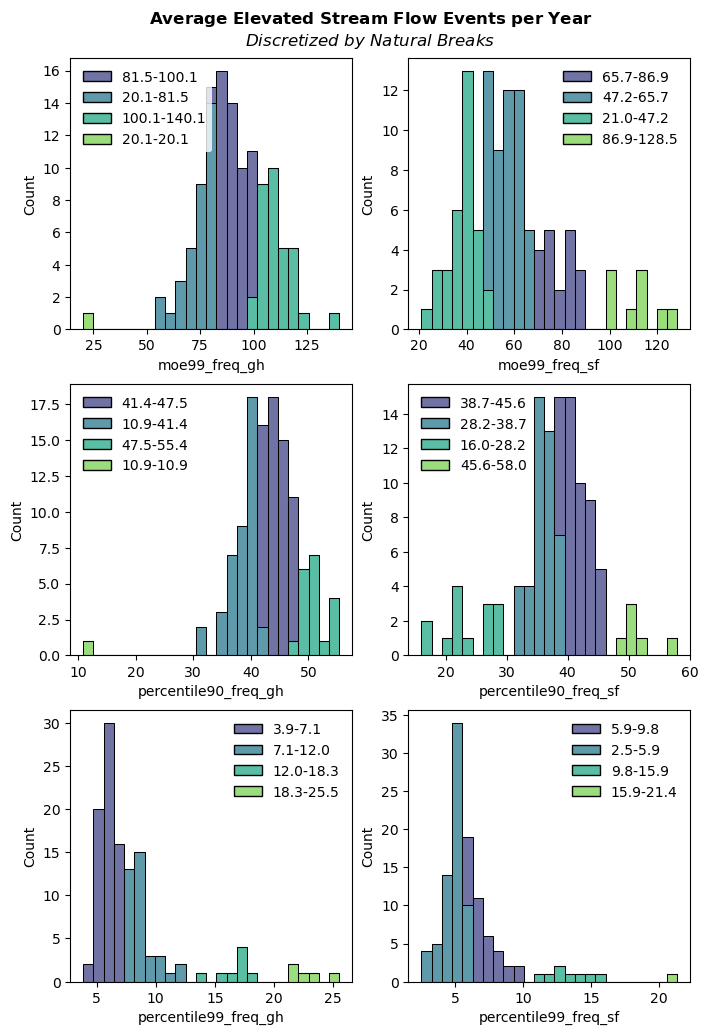

In [14]:
# plot distributions of frequencies by frequency type (threshold type)...
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8, 12))

ax = ax.ravel()

for i, col in enumerate(frequency_columns):

    categorical_col = col + '_cat'

    sns.histplot(data=watershed_mean_frequencies, 
                 x=col, 
                 hue=categorical_col, 
                 bins=25, 
                 palette='viridis', 
                 multiple='stack', 
                 ax=ax[i])
    
    legend = ax[i].get_legend()
    legend.set_title(None)
    legend.get_frame().set_edgecolor('none')

plt.suptitle(r'$\bf{Average\ Elevated\ Stream\ Flow\ Events\ per\ Year}$' + '\n' + r'$\it{Discretized\ by\ Natural\ Breaks}$', y=0.92)
plt.show()

## Save Files

In [15]:
# merge aggregated frequency dataframe with watershed geodataframe using watershed id column/index
gdf_watersheds = gdf_watersheds.merge(watershed_mean_frequencies, on='huc10', how='left', suffixes=('',''))

# display head of merged geodataframe
gdf_watersheds.head(3)

,loaddate,areasqkm,huc10,name,geometry,gauge,moe99_freq_gh,percentile90_freq_gh,percentile99_freq_gh,moe99_freq_sf,percentile90_freq_sf,percentile99_freq_sf,moe99_freq_gh_cat,moe99_freq_sf_cat,percentile90_freq_gh_cat,percentile90_freq_sf_cat,percentile99_freq_gh_cat,percentile99_freq_sf_cat
0,2023-04-03,580.98,0507020303,Johns Creek,"POLYGON ((881893.974 4190800.677, 881967.969 4...",1,81.522059,43.305147,6.823529,39.620000,26.680000,3.720000,20.1-81.5,21.0-47.2,41.4-47.5,16.0-28.2,3.9-7.1,2.5-5.9
1,2016-07-29,466.16,0509010110,Symmes Creek-Ohio River,"POLYGON ((894401.028 4297112.227, 894422.866 4...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-03-30,834.17,0510010111,Johnson Creek-Licking River,"POLYGON ((744167.531 4274338.915, 744182.905 4...",1,107.882353,42.882353,7.411765,99.347826,44.869565,8.304348,100.1-140.1,86.9-128.5,41.4-47.5,38.7-45.6,7.1-12.0,5.9-9.8


In [16]:
# save frequency data as new csv file...
# NOTE: shapefiles don't support column names > 10 characters, so converting 'geometry' to WKT, then saving as .csv

# path for new shapefile
output_shapefile_path = r'KY_WatershedEventFrequencies_26916.csv'

# convert geometry to wkt (well known text) dytpe
# gdf_watersheds['geometry'] = gdf_watersheds['geometry'].to_wkt()
gdf_save = gdf_watersheds.to_wkt()

# save to csv
gdf_save.to_csv(output_shapefile_path, index=False)

# EXAMPLE READING IN CSV WITH WKT GEOMETRY...
# df = pd.read_csv(path_to_csv)
# df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry'])
# gdf = gpd.GeoDataFrame(df, geometry='geometry')

## Plot Watershed Choropleth Maps

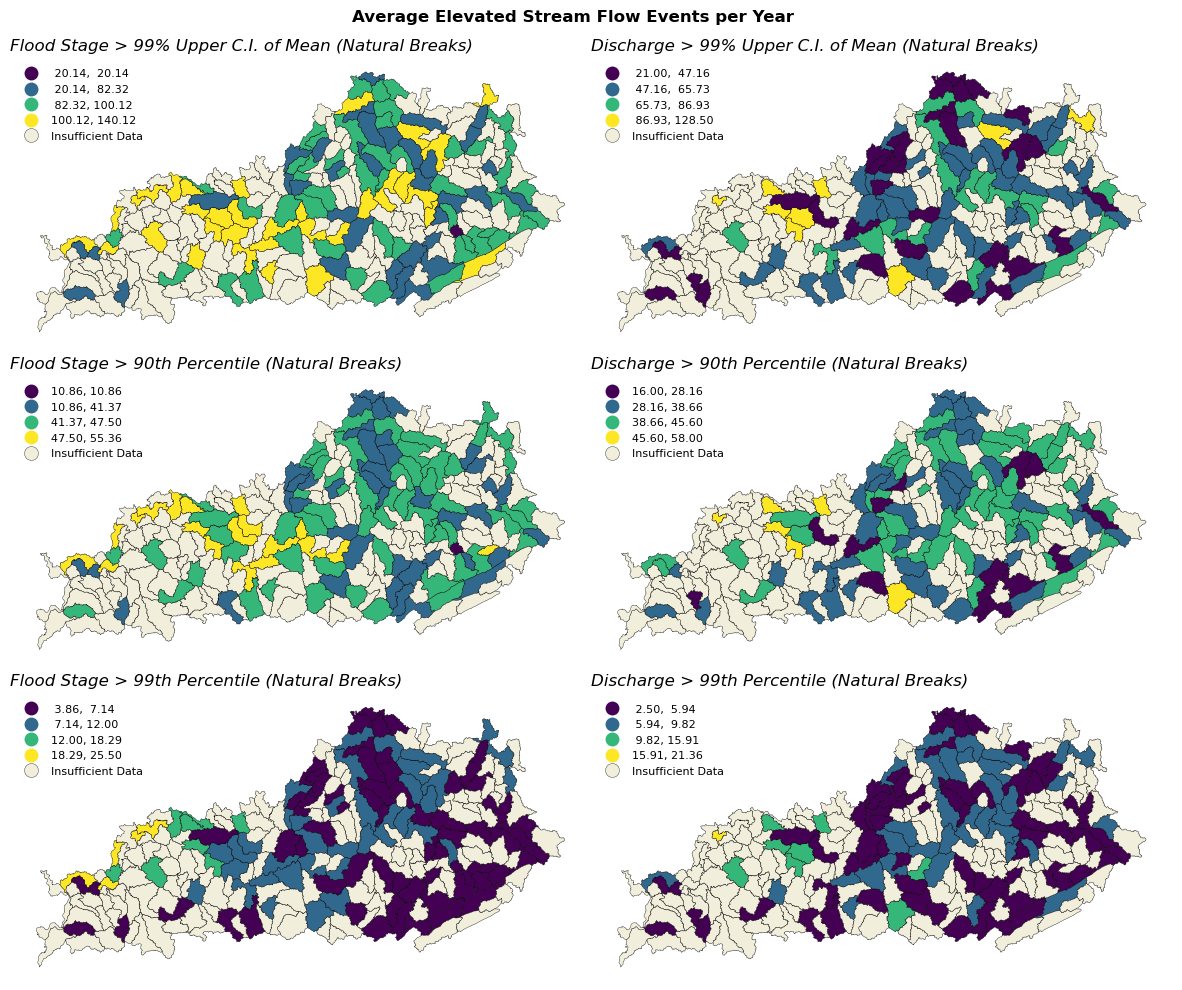

In [76]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,12))

ax = ax.ravel()

for i, count_col in enumerate(sorted([col for col in gdf_watersheds if ('cat' not in col) and (('gh' in col) or ('sf' in col))])):

    gdf_watersheds.plot(ax=ax[i], column=count_col, scheme='naturalbreaks', k=4, linewidth=0.25, edgecolor='k', 
                        missing_kwds={'color':'#F1EEDC', 'linewidth':0.25, 'edgecolor':'k', 'label':'Insufficient Data'}, 
                        legend=True, legend_kwds={'fontsize':8, 'frameon':False, 'loc':'upper left', 'bbox_to_anchor':(0,1), 'ncols':1})
    
    if 'gh' in count_col:
        data_type='Flood Stage'
    else:
        data_type='Discharge'

    if 'moe' in count_col:
        threshold = count_col[3:5] +'% Upper C.I. of Mean'
    else:
        threshold = count_col[10:12] + 'th Percentile'

    figure_title = f'\n{data_type} > {threshold} (Natural Breaks)'
    ax[i].set_title(label=figure_title, style='italic', loc='left', y=1)
    ax[i].set_axis_off()

plt.suptitle('Average Elevated Stream Flow Events per Year', weight='bold', y=0.92)
plt.subplots_adjust(hspace=0.1, wspace=0)
plt.show()